In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from src.data.dataset import ColorizationDataset
from src.model.generator.unet import Unet
from src.model.pix2pix import Pix2Pix

from torchvision import transforms
import torchvision.transforms.functional as T

from utils import set_random_seed

import tqdm
from tqdm import tqdm
from IPython.display import clear_output
import sys
import matplotlib.pyplot as plt
import numpy as np
from utils import Color, freeze_weights
import wandb

In [2]:
RANDOM_STATE = 322
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

set_random_seed(RANDOM_STATE)

In [3]:
from config import PIX2PIX_CONFIG

cfg = PIX2PIX_CONFIG
data_cfg = cfg.data
G_cfg = cfg.model.generator
D_cfg = cfg.model.discriminator
opt_cfg = cfg.optimizer
log_cfg = cfg.log
train_cfg = cfg.train

Объявляем датасеты и трансформации картинок. Так как картинки у меня в датасете могут быть довольно большого разрешения, я сначала сжимаю их до размера $512$ по наименьшей стороне, а затем делаю random crop картинки размера $256 \times 256$.

In [4]:
image_resolution = data_cfg.img_resolution

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize(image_resolution),
    transforms.RandomCrop(image_resolution),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize(image_resolution),
    transforms.RandomCrop(image_resolution),
    transforms.ToTensor(),
])
grayscale = transforms.Grayscale(1)

train_dataset = ColorizationDataset(data_cfg.train_dir, transform=train_transform)
val_dataset = ColorizationDataset(data_cfg.val_dir, transform=val_transform,
                                  valid=True, scale_factor=image_resolution)

train_dataloader = DataLoader(train_dataset, batch_size=train_cfg.batch_size,
                              shuffle=True,  num_workers=7, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_cfg.batch_size,
                            shuffle=False, num_workers=7)

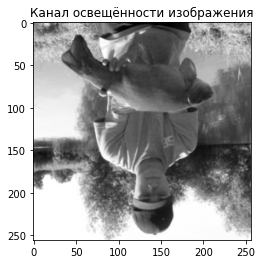

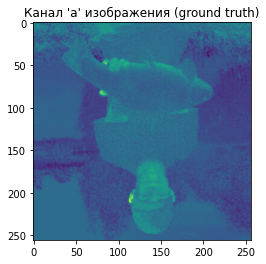

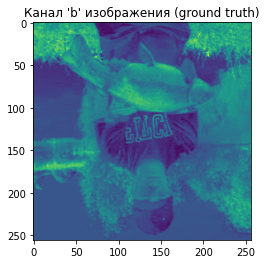

In [5]:
img = train_dataset[0]
plt.imshow(img[0].numpy().squeeze(), cmap="gray")
plt.title("Канал освещённости изображения")
plt.show()
plt.imshow(img[1][0].numpy().squeeze())
plt.title("Канал 'a' изображения (ground truth)")
plt.show()
plt.imshow(img[1][1].numpy().squeeze())
plt.title("Канал 'b' изображения (ground truth)")
plt.show()

### Train loop

Напишем тут пару функций для обучения generator на минимизацию l1, без adversarial objective.
Так же напишем функцию, которая проверяет результат обучения модели на нескольких изображениях из валидационного датасета. Можно заметить, что в валидационный датасет я изначально не передавал никаких трансформаций, так что модель будет стараться раскрасить картинку в исходном разрешении.

Так же функция для преобразования Lab картинки обратно в RGB.

In [6]:
def train_epoch(model, optim, criterion, train_loader):
    model.train()
    losses = []
    with tqdm(total=len(train_loader)) as prbar:
        for L, ab, stats in train_loader:
            L = L.to(DEVICE, non_blocking=True)
            ab = ab.to(DEVICE, non_blocking=True)
            pred_ab = model(L)
            loss = criterion(pred_ab, ab)
            loss.backward()
            optim.step()
            optim.zero_grad()
            prbar.set_description(
              f"Loss: {loss.item()} "
            )
            prbar.update(1)
            losses.append(loss.item())
    return np.mean(losses)

def train(model, optim, criterion, train_loader, val_loader, epoches=6):
    model.to(DEVICE)
    train_losses = []
    for epoch in range(epoches):
        epoch_loss = train_epoch(model, optim, criterion, train_loader)
        train_losses.append(epoch_loss)
        clear_output()
        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(len(train_losses)), train_losses, c="C1", label="train_loss")
        plt.show()

In [7]:
@torch.inference_mode()
def eval(model, val_dataset, ids=None):
    preds = []
    if ids is None:
        ids = torch.randint(len(val_dataset), size=(5,))
    for idx in ids:
        L, ab, stats = val_dataset[idx]
        L = L.to(DEVICE).unsqueeze(0)
        pred_ab = model(L)
        preds.append(pred_ab.squeeze())
    return preds, ids

def construct_img(L, ab, stats):
    img = torch.cat([L.cpu(), ab.cpu()], dim=0)
    img = img * 0.5 + 0.5
    img = img * (stats[1].item() - stats[0].item()) + stats[0].item()
    img = torch.tensor(Color.lab2rgb(img.permute(1, 2, 0)))#.permute(2, 0, 1)
    return img.numpy().squeeze()

In [8]:
def show(imgs, img_size=(5, 5)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), figsize=(5 * img_size[0], 5 * img_size[1]), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = T.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Overfit

Постараемся переобучить модель на одном батче, прогнав модель через него 100 раз. В результате мы ожидаем, что модель научится неплохо восстанавливать цвета конкретно для этого батча.

In [23]:
# model = Unet(3, 1, 64, 2, 32).to(DEVICE)
model = Unet(5, 1, 512, 2, 64).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = torch.nn.L1Loss()

In [24]:
for L, ab, stats in train_dataloader:
    ab = ab.to(DEVICE)
    L = L.to(DEVICE)
    for i in range(100):
        pred = model(L)
        loss = criterion(pred, ab)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    break

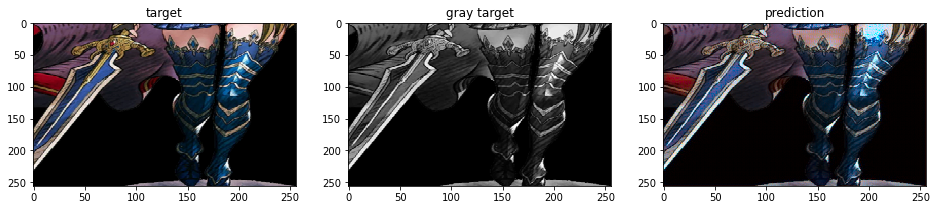

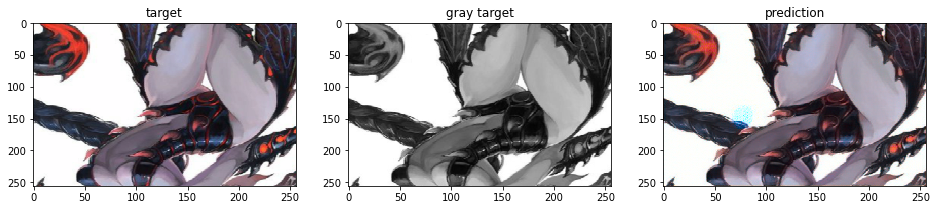

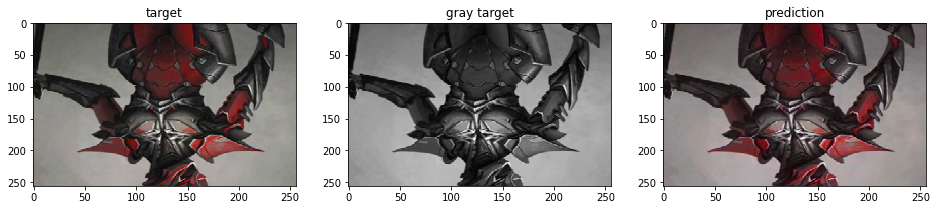

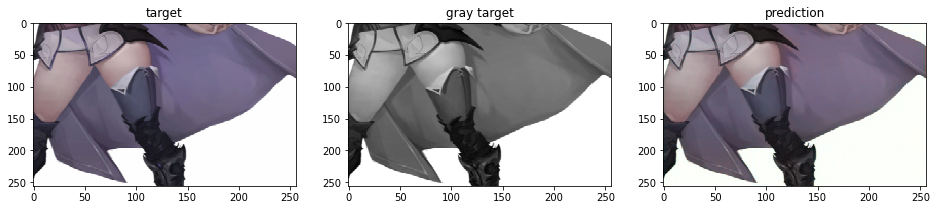

In [25]:
with torch.no_grad():
    for i in range(4):
        plt.figure(figsize = (16,3))
        
        pred_img = construct_img(L[i].cpu(), pred[i].cpu(), stats[i].cpu())
        true_img = construct_img(L[i].cpu(), ab[i].cpu(), stats[i].cpu())

        plt.subplot(1, 3, 1)
        plt.title("target")
        plt.imshow(true_img, interpolation='nearest', aspect='auto')
        plt.subplot(1, 3, 2)
        plt.title("gray target")
        plt.imshow(L[i].cpu().squeeze(), cmap="gray", interpolation='nearest', aspect='auto')
        plt.subplot(1, 3, 3)
        plt.title("prediction")
        plt.imshow(pred_img, interpolation='nearest', aspect='auto')
        plt.show()

На тренировачном батче модель действительно неплохо себя показывает. Теперь посмотрим, что происходит на валидационном датасете.

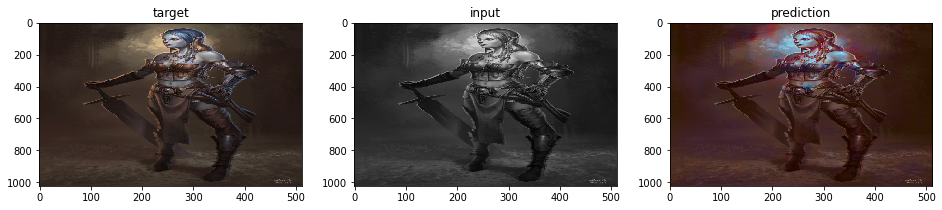

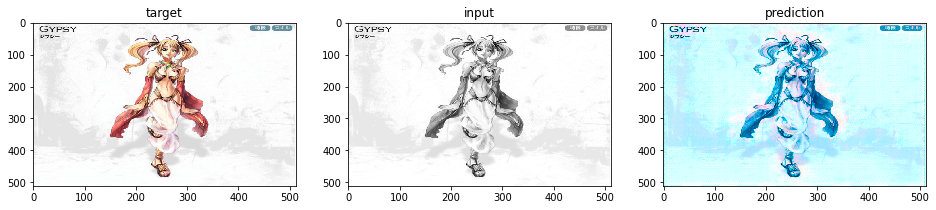

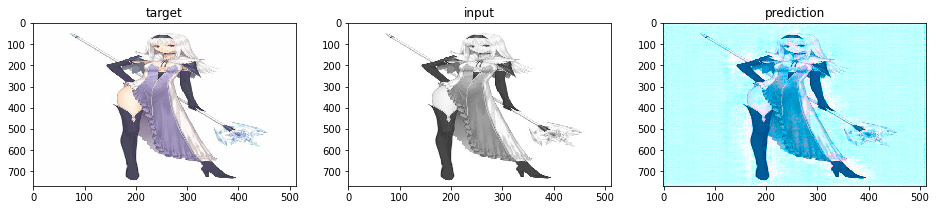

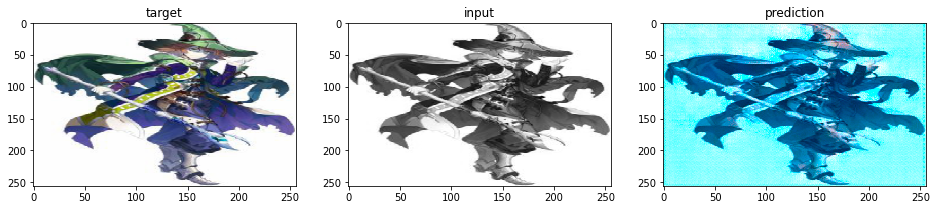

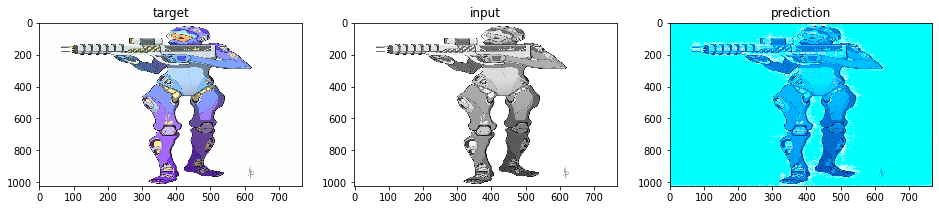

In [26]:
p, t = eval(model, val_dataset)

for row in range(len(p)):
    plt.figure(figsize = (16,3))
    L, true_ab, stats = val_dataset[t[row]]
    
    pred_img = construct_img(L, p[row], stats)
    true_img = construct_img(L, true_ab, stats)
    
    plt.subplot(1, 3, 1)
    plt.title("target")
    plt.imshow(true_img, interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 2)
    plt.title("input")
    plt.imshow(L.squeeze(), cmap="gray", interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 3)
    plt.title("prediction")
    plt.imshow(pred_img, interpolation='nearest', aspect='auto')
    plt.show()

Модель показала себя очень плохо, впрочем, как и должна была.

### L1 Training

Теперь обучим модель на всём тренировочном датасете втечение 10 эпох и протестируем на валидационном датасете.

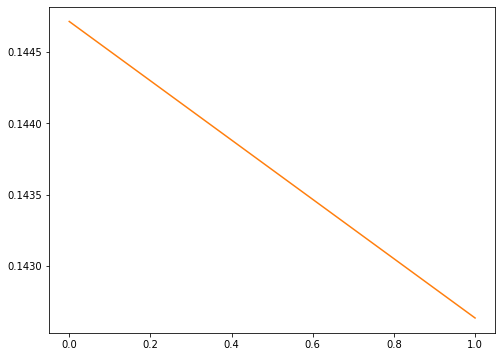

Loss: 0.14182761311531067 :  41%|████      | 1251/3076 [02:26<03:58,  7.64it/s]

In [ ]:
model = Unet(5, 1, 512, 2, 64).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = torch.nn.L1Loss()
train(model, optimizer, criterion, train_dataloader, val_dataloader, epoches=10)

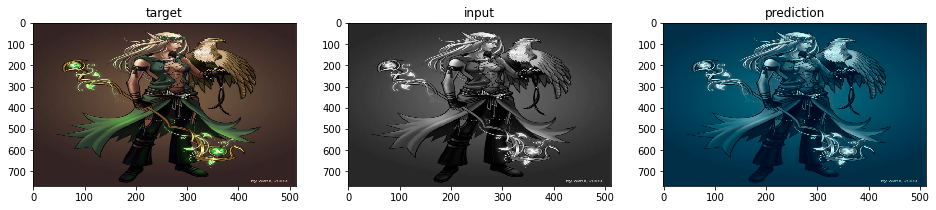

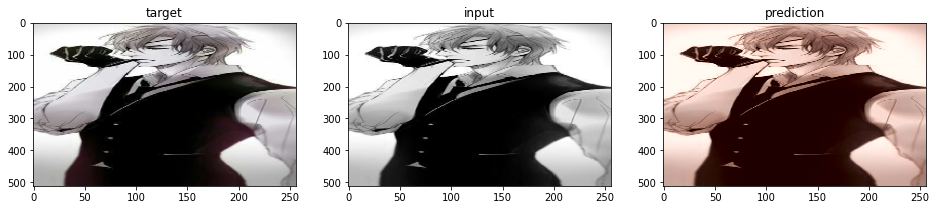

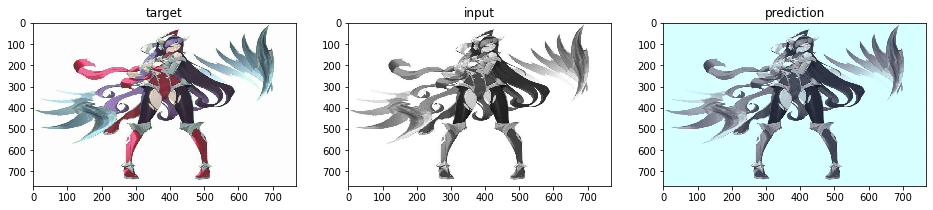

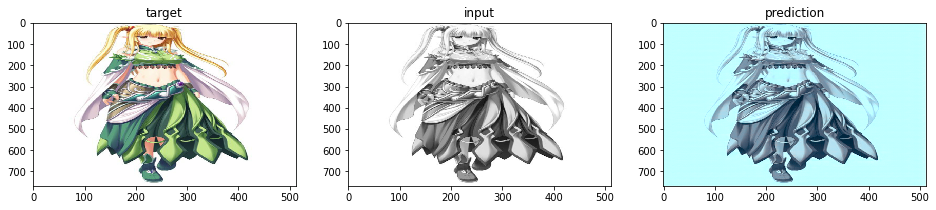

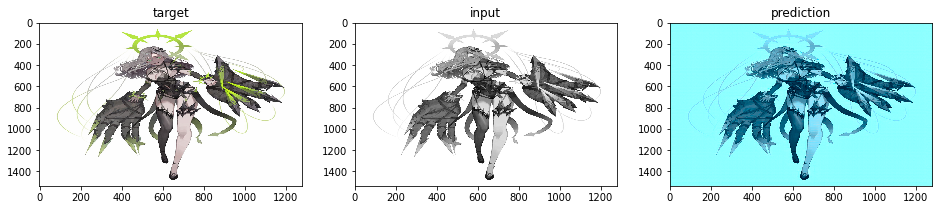

In [29]:
p, t = eval(model, val_dataset)

for row in range(len(p)):
    plt.figure(figsize = (16,3))
    L, true_ab, stats = val_dataset[t[row]]
    
    pred_img = construct_img(L, p[row], stats)
    true_img = construct_img(L, true_ab, stats)
    
    plt.subplot(1, 3, 1)
    plt.title("target")
    plt.imshow(true_img, interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 2)
    plt.title("input")
    plt.imshow(L.squeeze(), cmap="gray", interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 3)
    plt.title("prediction")
    plt.imshow(pred_img, interpolation='nearest', aspect='auto')
    plt.show()

Стрёмный синий фильтр вместо нормальных предсказаний

### Adversarial training

In [9]:
@torch.inference_mode()
def eval(model, val_dataset, ids=None):
    preds = []
    if ids is None:
        ids = torch.randint(len(val_dataset), size=(5,))
    for idx in ids:
        L, ab, stats = val_dataset[idx]
        L = L.to(DEVICE).unsqueeze(0)
        pred_ab = model.generator(L)
        preds.append(pred_ab.squeeze())
    return preds, ids

def construct_img(L, ab, stats):
    res = torch.Tensor()
    for i in range(L.shape[0]):
        img = torch.cat([L[i].cpu(), ab[i].cpu()], dim=0)
        img = img * 0.5 + 0.5
        img = img * (stats[i, 1].item() - stats[i, 0].item()) + stats[i, 0].item()
        img = torch.tensor(Color.lab2rgb(img.permute(1, 2, 0))).permute(2, 0, 1).unsqueeze(0)
        res = torch.cat([res, img])
    return res

def construct_grid(model, val_dataset):
    pred_ab, ids = eval(model, val_dataset)
    L, true_ab, stats = torch.Tensor(), torch.Tensor(), torch.Tensor()
    for idx in ids:
        L_, true_ab_, stats_ = val_dataset[idx]
        L = torch.cat([L, L_.unsqueeze(0)])
        true_ab = torch.cat([true_ab, true_ab_.unsqueeze(0)])
        stats = torch.cat([stats, stats_.unsqueeze(0)])

    target_imgs = construct_img(L, true_ab, stats)
    colored_imgs = construct_img(L, pred_ab, stats)

    target_imgs = make_grid(target_imgs.permute(0, 1, 3, 2)).permute(0, 2, 1)
    L = make_grid(L.permute(0, 1, 3, 2)).permute(0, 2, 1)
    colored_imgs = make_grid(colored_imgs.permute(0, 1, 3, 2)).permute(0, 2, 1)

    grid = torch.cat([target_imgs, L, colored_imgs], dim=2)
    return grid

In [12]:
def train_epoch(model, optims, train_loader):
    model.train()
    G_losses = []
    D_losses = []
    D_optim = optims[0]
    G_optim = optims[1]
    G_l1_losses = []
    G_ce_losses = []
    D_true_losses = []
    D_false_losses = []
    with tqdm(total=len(train_loader)) as prbar:
        for step, (L, ab, stats) in enumerate(train_loader):
            L = L.to(DEVICE, non_blocking=True)
            ab = ab.to(DEVICE, non_blocking=True)
            generated_img = model.generator(L)
            
            D_optim.zero_grad()
            freeze_weights(model.descriminator, freeze=False)
            desc_loss = model([L, generated_img], true_output=ab, G_step=False)
            desc_loss[0].backward()
            D_optim.step()

            G_optim.zero_grad()
            freeze_weights(model.descriminator, freeze=True)
            generator_loss = model([L, generated_img], true_output=ab, G_step=True)
            generator_loss[0].backward()
            G_optim.step()
            
            G_losses.append(generator_loss[0].item())
            G_ce_losses.append(generator_loss[1].item())
            G_l1_losses.append(generator_loss[2].item())
            D_losses.append(desc_loss[0].item())
            D_true_losses.append(desc_loss[1].item())
            D_false_losses.append(desc_loss[2].item())

            prbar.set_description(
              f"G-loss: {generator_loss[0].item()} , D-loss: {desc_loss[0].item()}"
            )
            prbar.update(1)
            
            if step % log_cfg.steps == 0:
                wandb.log({
                    "D_loss": np.mean(D_losses),
                    "G_loss": np.mean(G_losses),
                    "G_ce_loss": np.mean(G_ce_losses),
                    "G_l1_loss": np.mean(G_l1_losses),
                    "D_true_loss": np.mean(D_true_losses),
                    "D_false_loss": np.mean(D_false_losses),
                })
    return np.mean(D_losses), np.mean(G_losses)

def train(model, optims, train_loader, val_dataset, epoches=6, schedulers=None):
    model.to(DEVICE)
    train_losses_D = []
    train_losses_G = []
    for epoch in range(epoches):
        D_loss, G_loss = train_epoch(model, optims, train_loader)
        train_losses_D.append(D_loss)
        train_losses_G.append(G_loss)
        clear_output()
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(len(train_losses_D)), train_losses_D, c="C1", label="D_loss")
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(len(train_losses_G)), train_losses_G, c="C2", label="G_loss")
        plt.show()
        
        if schedulers is not None:
            schedulers[0].step()
            schedulers[1].step()
        
        if log_cfg.log_per_epoch:
            grid = construct_grid(model, val_dataset)
            images = wandb.Image(grid, caption="Target, model input and output")
            wandb.log({"examples": images})

In [19]:
model = Pix2Pix(5, 5, 1, 512, 2, 64).to(DEVICE)
optimizer_discriminator = torch.optim.Adam(model.descriminator.parameters(),
                                           lr=0.0002, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(model.generator.parameters(),
                                       lr=0.0002, betas=(0.5, 0.999))

In [20]:
for L, ab, stats in train_dataloader:
    ab = ab.to(DEVICE)
    L = L.to(DEVICE)
    for i in range(1_00):
        L = L.to(DEVICE, non_blocking=True)
        ab = ab.to(DEVICE, non_blocking=True)
        generated_img = model.generator(L)

        freeze_weights(model.descriminator, freeze=False)
        desc_loss = model([L, generated_img], true_output=ab, G_step=False)
        desc_loss.backward()
        optimizer_discriminator.step()
        optimizer_discriminator.zero_grad()

        freeze_weights(model.descriminator, freeze=True)
        generator_loss = model([L, generated_img], true_output=ab, G_step=True)
        generator_loss[0].backward()
        optimizer_generator.step()
        optimizer_generator.zero_grad()
    break

In [25]:
L.shape

torch.Size([3, 1034, 260])

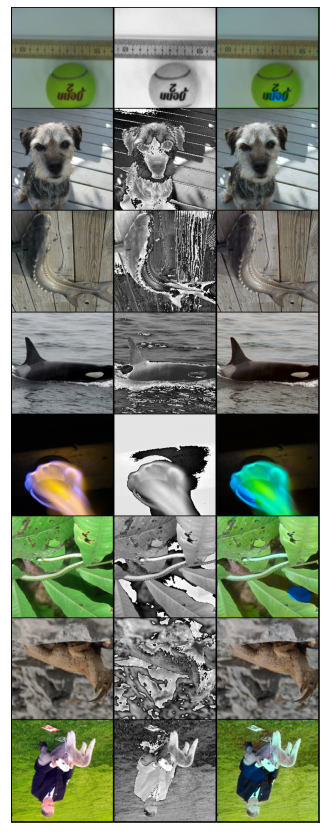

In [21]:
with torch.no_grad():
    target_imgs = construct_img(L.cpu(), ab.cpu(), stats)
    colored_imgs = construct_img(L.cpu(), generated_img.cpu(), stats)
    
    target_imgs = make_grid(target_imgs.permute(0, 1, 3, 2)).permute(0, 2, 1)
    L = make_grid(L.cpu().permute(0, 1, 3, 2)).permute(0, 2, 1)
    colored_imgs = make_grid(colored_imgs.permute(0, 1, 3, 2)).permute(0, 2, 1)

    grid = torch.cat([target_imgs, L.cpu(), colored_imgs], dim=2)
    show(grid, img_size=(2, 3))

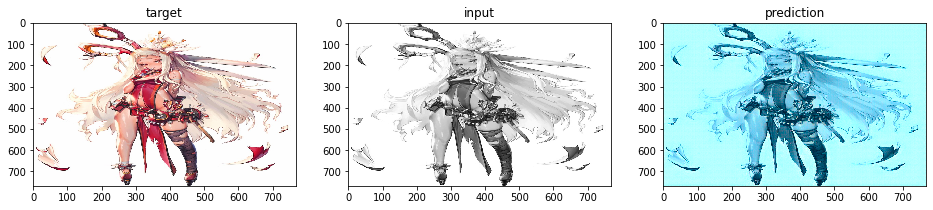

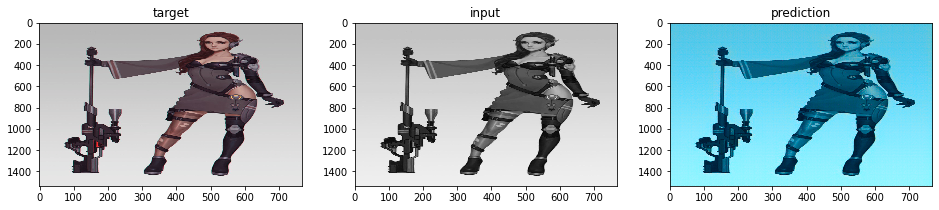

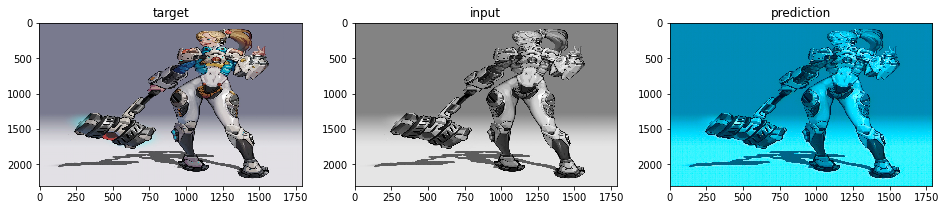

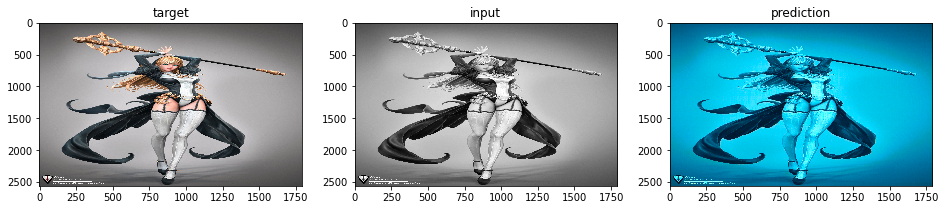

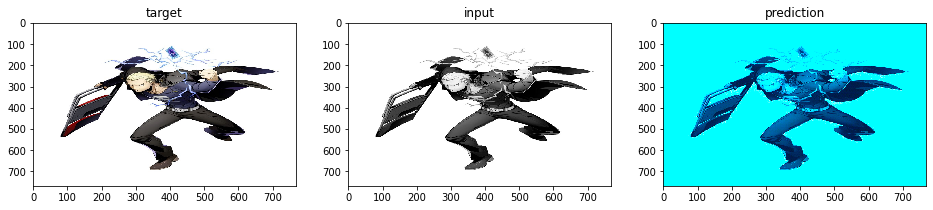

In [28]:
p, t = eval(model, val_dataset)

for row in range(len(p)):
    plt.figure(figsize = (16,3))
    L, true_ab, stats = val_dataset[t[row]]
    
    pred_img = construct_img(L, p[row], stats)
    true_img = construct_img(L, true_ab, stats)
    
    plt.subplot(1, 3, 1)
    plt.title("target")
    plt.imshow(true_img, interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 2)
    plt.title("input")
    plt.imshow(L.squeeze(), cmap="gray", interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 3)
    plt.title("prediction")
    plt.imshow(pred_img, interpolation='nearest', aspect='auto')
    plt.show()

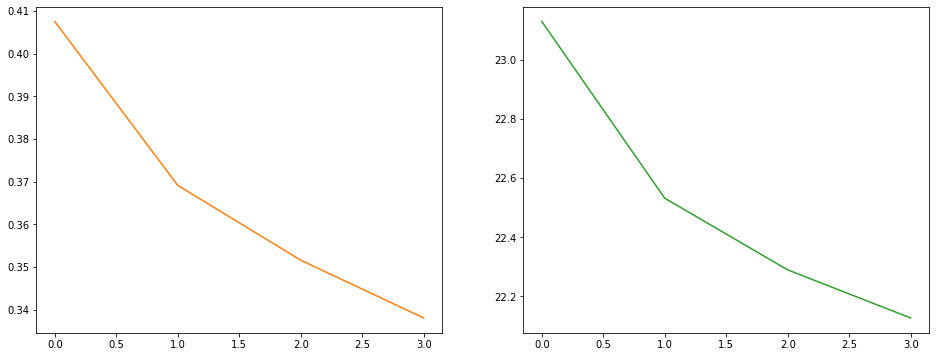

G-loss: 21.920759201049805 , D-loss: 0.44565480947494507:  43%|████▎     | 3739/8687 [10:45<13:01,  6.33it/s] 

In [ ]:
run_name = "adjuscted_train_v3"

with wandb.init(project="img2img", entity="johan_ddc_team", config=cfg, name=run_name):
    model = Pix2Pix(generator_n_layers=G_cfg.num_layers+1,
                    descriminator_n_layers=D_cfg.num_layers,
                    in_channels=G_cfg.in_channels,
                    inner_channels=G_cfg.inner_channels,
                    out_channels=G_cfg.out_channels,
                    start_num_filters=G_cfg.start_num_filters).to(DEVICE)
    
    optimizer_discriminator = torch.optim.Adam(model.descriminator.parameters(),
                                               lr=opt_cfg.lr, betas=opt_cfg.betas)
    optimizer_generator = torch.optim.Adam(model.generator.parameters(),
                                           lr=opt_cfg.lr, betas=opt_cfg.betas)
    optimizers = [optimizer_discriminator, optimizer_generator]
    
    scheduler_discriminator = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_discriminator,
                                                            T_max=train_cfg.num_epoches, eta_min=0)
    scheduler_generator = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_generator,
                                                            T_max=train_cfg.num_epoches, eta_min=0)
    schedulers=[scheduler_discriminator, scheduler_generator]
    
    wandb.watch(model, log="all", log_freq=10)
    train(model, optimizers, train_dataloader, val_dataset,
          epoches=train_cfg.num_epoches, schedulers=schedulers)

In [13]:
torch.save(model.state_dict(), "checkpoint.pth")

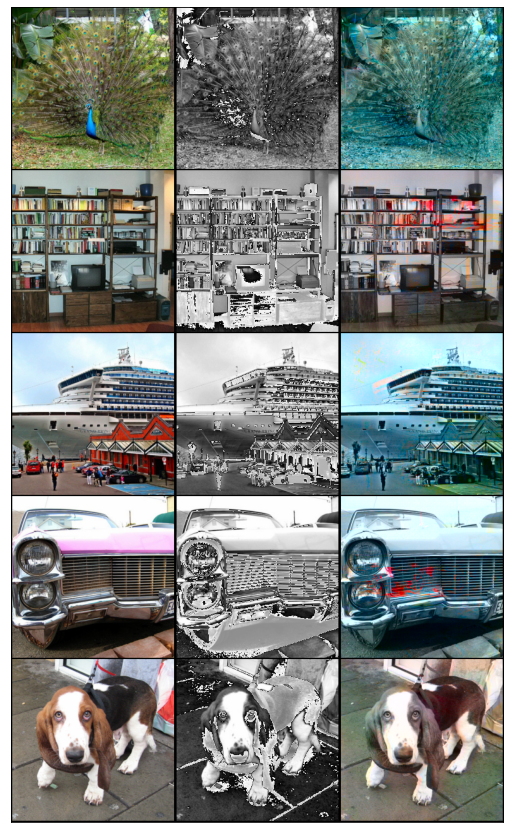

In [18]:
model.train()
grid = construct_grid(model, val_dataset)
show(grid, img_size=(2, 3))